# Explaining Acquisition Functions
"Acquisition functions" are the tools used to assign value to individual experiments. 
We demonstrate [a few of the commons ones](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Acquisition-functions.html) in this notebook.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np

## Generate Target Function and Model
We use the target function from [modAL's documentation](https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html) as an example.

In [2]:
X = np.linspace(0, 20, 1000)
y = np.sin(X)/2 - ((10 - X)**2)/50 + 2

In [3]:
X = np.expand_dims(X, 1)  # Makes X into a 2D array, as expected by sklearn

Pick a few points and train an initial model

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5)

In [5]:
kernel = Matern()
model = GaussianProcessRegressor(kernel=kernel)

In [6]:
model.fit(X_train, y_train)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5))

Plot the results

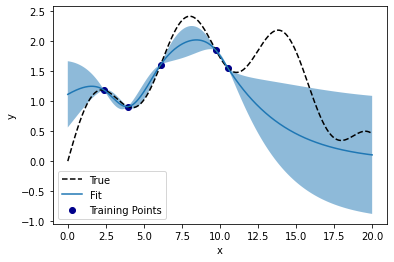

In [7]:
fig, ax = plt.subplots()

ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

## Explore Acquisition Functions
Acquisition functions define the value of sampling a certain point on [achieving an experimental objective](https://distill.pub/2020/bayesian-optimization/). 
These objectives could be to minimize the total uncertainty over a space or to find an optimal value of a function.
In this section, we demonstrate different aquistion functions to illustrate the different ways we can choose to explore this space.

### Random Sampling
Assigning a random value to each point is a perfectly valid acquistion function. 
We can write the function out as: $a_{random}(x) = U(0, 1)$
where $a(x)$ is the value for point $x$ and $U$ is the uniform distribution.

In [8]:
value = np.random.uniform(size=len(X))

In [9]:
chosen_point = np.argmax(value)

Text(0.5, 0, 'x')

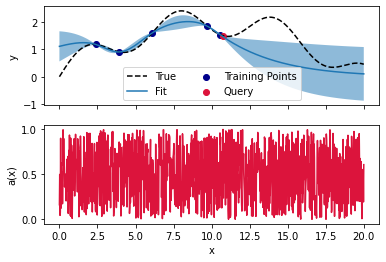

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')
ax.scatter([X[chosen_point]], y[chosen_point], label='Query', color='crimson')

ax.set_ylabel('y')
ax.legend(ncol=2)

ax = axs[1]

ax.plot(X, value, color='crimson')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')


There is no logic to how this point is chosen

### Greedy Sampling
Another simple strategy is to value a point based only on the mean prediction: $a_{greedy} = \mu(x)$
where $\mu$ is the mean of model's predictions at point

In [11]:
value = model.predict(X)

In [12]:
chosen_point = np.argmax(value)

Text(0.5, 0, 'x')

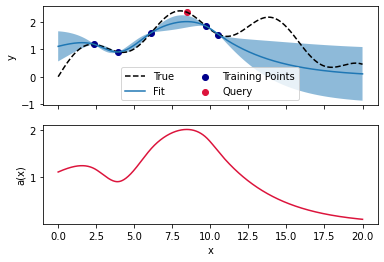

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')
ax.scatter([X[chosen_point]], y[chosen_point], label='Query', color='crimson')

ax.set_ylabel('y')
ax.legend(ncol=2)

ax = axs[1]

ax.plot(X, value, color='crimson')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')

Given the choice of a model form that is a summation over radial-basis functions (i.e., [Matérn functions](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function)), the chosen point is likely to be very close to the maximum value from the training points.

### Probability of Improvement
Another common acquisition function is to compute the likelihood that a point will be above a certain threshold.
Customariliy, the threshold is the often the maximum of the training points (i.e., $f' = \max f$).
If we assume the probability distribution of values for a certain points are modeled by normal distribution, the 
probability of improvement can be exprssed as:

$a_{PI}(x) = 1 - \Phi(f', \mu(x), \sigma(x))$

where $\Phi$ is the cumulative distribution function for the normal distribution and $\sigma$ is the predicted standard deviation of for point $x$.
See [Roman Garnett's lecture notes](https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf) for a derivation.

In [14]:
y_pred, y_std = model.predict(X, return_std=True)
f_max = np.max(y_train)
value = [1 - stats.norm(u, s).cdf(f_max) for u, s in zip(y_pred, y_std)]

In [15]:
chosen_point = np.argmax(value)

Text(0.5, 0, 'x')

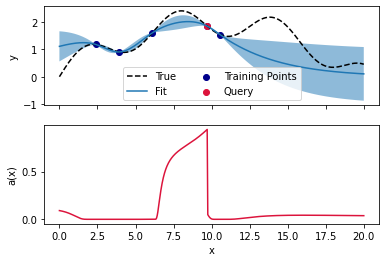

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')
ax.scatter([X[chosen_point]], y[chosen_point], label='Query', color='crimson')

ax.set_ylabel('y')
ax.legend(ncol=2)

ax = axs[1]

ax.plot(X, value, color='crimson')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')

Note that the $a$ value for the best point from the training set will be 0.5 because $\mu = f'$ for this point, meaning that 50% of the distribution lies above the chosen point.

### Upper Confidence Bounds (UCB)
The "upper confidence bound" (UCB) expresses the value for a point as a tradeoff between exploitation and exploration:

$a_{UCB}(x) = \mu(x) + \beta\sigma(x)$

where $\beta$ is a tradeoff parameter. Larger values of $\beta$ will lead to greater weight to uncertainty ($\sigma$) and, thereby, more exploration

In [17]:
y_pred, y_std = model.predict(X, return_std=True)
value_1 = y_pred + y_std
value_2 = y_pred + 2 * y_std

In [18]:
chosen_point_1 = np.argmax(value_1)
chosen_point_2 = np.argmax(value_2)

Text(0.5, 0, 'x')

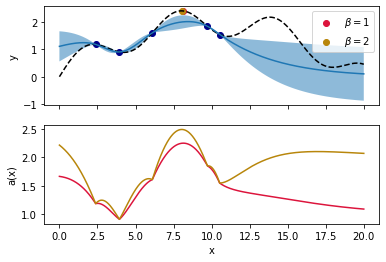

In [19]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X))
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, color='darkblue')
ax.scatter([X[chosen_point_1]], y[chosen_point_1], label='$\\beta=1$', color='crimson')
ax.scatter([X[chosen_point_2]], y[chosen_point_2], label='$\\beta=2$', color='darkgoldenrod')

ax.set_ylabel('y')
ax.legend()

ax = axs[1]

ax.plot(X, value_1, color='crimson', label='$\\beta=1$')
ax.plot(X, value_2, color='darkgoldenrod', label='$\\beta=2$')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')

Note how $\beta=1$ samples a point with higher uncertainty but still with a larger mean prediction.